<a href="https://colab.research.google.com/github/dbasso98/Unsupervised-Learning/blob/main/second_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2 - Kernel PCA

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='dark')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 
from utils import PCA, normalize, plot_semilogy, get_explained_variance
import scipy as sp

First of all, let's load the dataset retrieved from: https://github.com/alexdepremia/Unsupervised-Learning-Datasets

In [ ]:
# Data and labels loading
data = np.loadtxt('data/data_kPCA_2022-2023.txt', dtype=float)
labels = np.loadtxt('data/labels_kPCA_2022-2023.txt', dtype=int)
# Data dimension
print(f'The original dimension of the dataset is: {data.shape}')
# Normalize the dataset
data = normalize(data)

The original dimension of the dataset is: (6632, 20)


1. Divide your data set into two parts. One would be employed as test set, while the other would be employed as learning set.

In [ ]:
# Dataset subdivision into training and test set
# Let's pick the first 6000 observations as training set and the last 632 as test set
train_size, test_size = 6000, 632
# We can also shuffle the data
shuffle_idx = np.random.permutation(len(data))
data = data[shuffle_idx]
labels = labels[shuffle_idx]
train_data, test_data, train_labels, test_labels = data[:train_size], data[-test_size:], labels[:train_size], labels[-test_size:]

2. Use the program from the previous exercise for computing the Principal Components Analysis on the learning dataset. Obtain and plot the eigenvalue spectrum. Project the data in the two first PCs and color it by label.

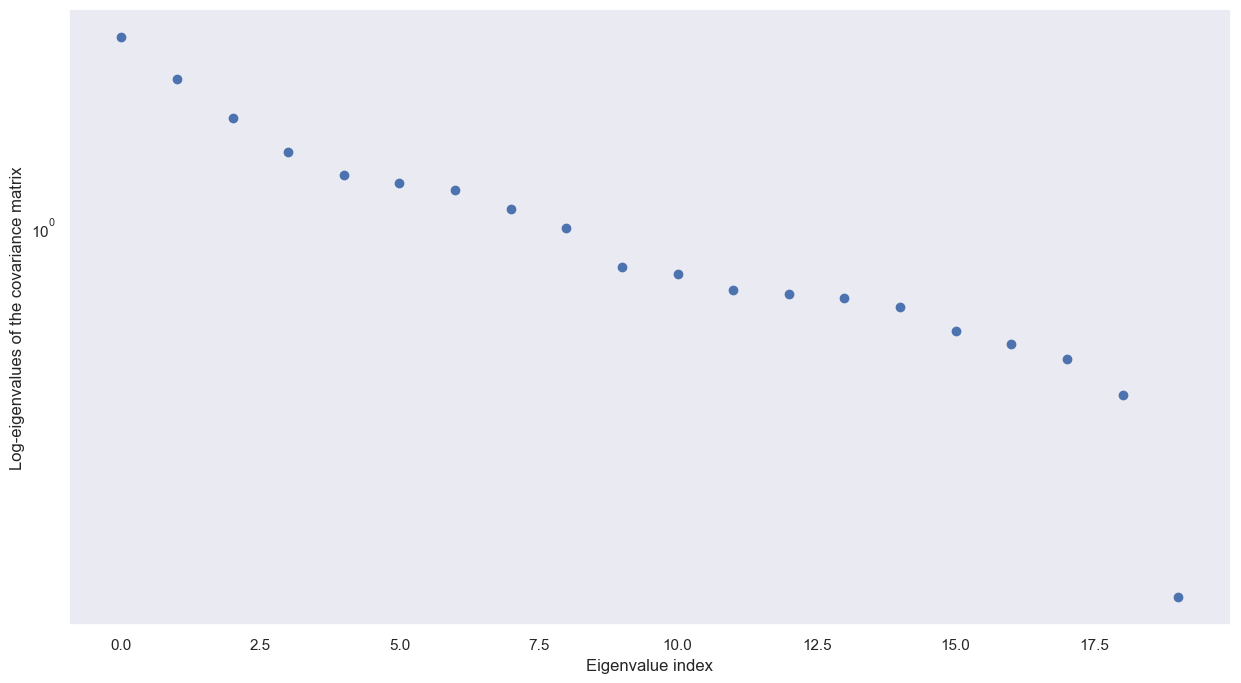

In [ ]:
# Perform PCA 
eigenvalues, eigenvectors, Y = PCA(data, data.shape[1])

# Plot the eigenvalue spectrum
plt.figure(figsize=(15,8))
plt.semilogy(eigenvalues, 'o')
plt.ylabel("Log-eigenvalues of the covariance matrix")
plt.xlabel("Eigenvalue index")
plt.show()


In [ ]:
# We can check the explained variance per principal component
get_explained_variance(eigenvalues)

array([0.11468242, 0.21018046, 0.29075143, 0.36018901, 0.4229163 ,
       0.4834434 , 0.54223184, 0.59626598, 0.64610471, 0.68808536,
       0.72892352, 0.76694547, 0.80424771, 0.84087712, 0.87614791,
       0.90792685, 0.93798158, 0.96608931, 0.99007473, 1.        ])

Text(0.5, 1.0, 'PCA data projection on the first 2 Principal Components')

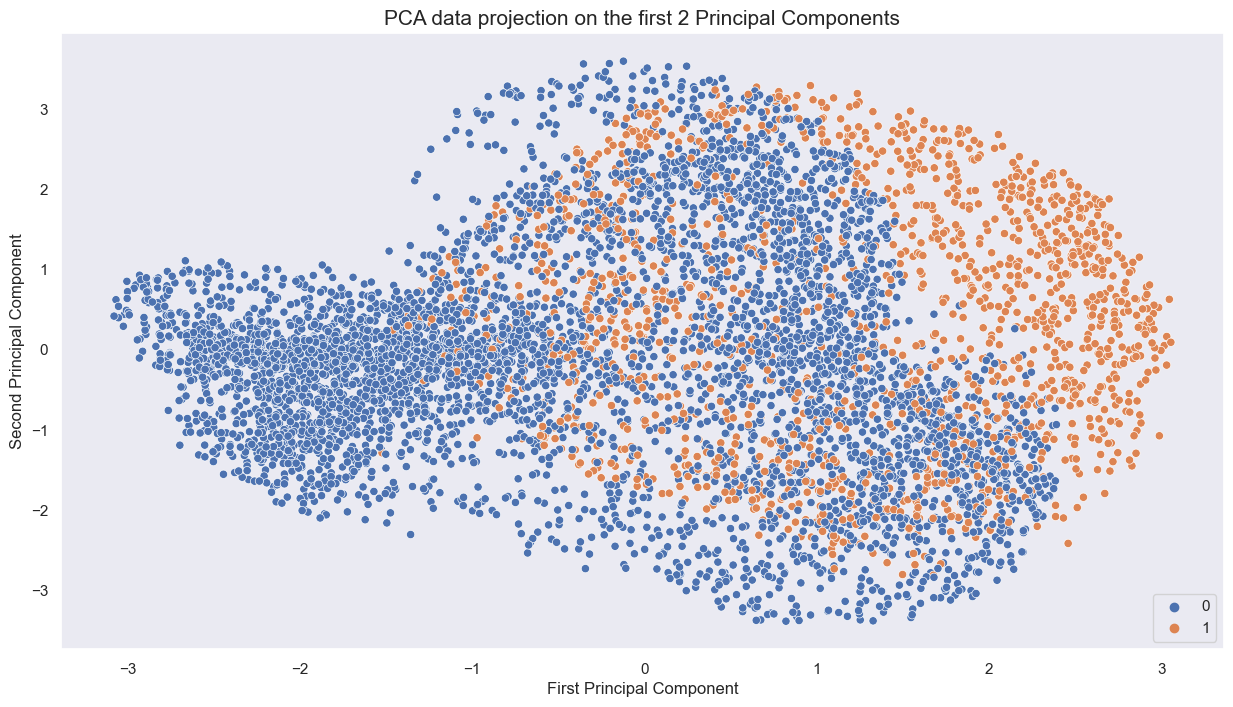

In [ ]:
# Project first two PCs
_, _, Y = PCA(data, 2)
plt.figure(figsize=(15,8))
sns.scatterplot(x = Y[:,0], y = Y[:,1], hue=labels)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend(loc='lower right',  bbox_to_anchor=(0.5, 0., 0.5, 0.5))
plt.title('PCA data projection on the first 2 Principal Components', fontsize=15)

3. For an increasing number of principal components (from 1 to 20):

    (a) Apply a logistic regression (you can program it yourself or use an external library) for learning a model in the learning data set.
    
    (b) Transform the coordinates of the test data set with the matrix learned from the learning data set and make a prediction based on the logistic model. Quantify the quality of the prediction by computing the Mutual Information between the ground truth classification and the predicted labels.

In [ ]:
def mutual_information(x, y):
    mutual_info = 0.0
    # Unique values of x and y
    x_values = np.unique(x)
    y_values = np.unique(y)
    # Probabilites of x and y, p(x) and p(y)
    p_x = np.array([len(x[x==x_value]) for x_value in x_values])/float(len(x))
    p_y = np.array([len(y[y==y_value]) for y_value in y_values])/float(len(y))
    for i, x_value in enumerate(x_values):
        if p_x[i] == 0:
            continue
        # Get the intersection between current x_value and y
        intersection = y[y==x_value]
        if len(intersection) == 0:
            continue
        p_x_y = np.array([len(intersection[intersection==y_value]) for y_value in y_values])/float(len(y))
        frac = p_x_y/(p_y*p_x)
        mutual_info += np.sum(p_x_y[p_x_y>0.0]*np.log(frac[frac>0.0]))

    return mutual_info


def logistic_regression_on_variable_PC(X, n_components):
    _, _, Y = PCA(X, n_components)
    Y_train, Y_test = Y[:train_size], Y[-test_size:]
    model = LogisticRegression()
    for n in range(1, n_components+1):
        model.fit(Y_train[:, :n], train_labels)
        result = model.predict(Y_test[:, :n])
        mutual_info = mutual_information(test_labels, result)
        print(f"Principal Components: {n}, Mutual Information: {mutual_info}")
        

In [ ]:
logistic_regression_on_variable_PC(data, 20)

Principal Components: 1, Mutual Information: 0.4340701869888943
Principal Components: 2, Mutual Information: 0.4103799799493435
Principal Components: 3, Mutual Information: 0.40445742818945574
Principal Components: 4, Mutual Information: 0.45578621010848286
Principal Components: 5, Mutual Information: 0.4518378422685576
Principal Components: 6, Mutual Information: 0.44986365834859515
Principal Components: 7, Mutual Information: 0.4538120261885203
Principal Components: 8, Mutual Information: 0.46368294578833313
Principal Components: 9, Mutual Information: 0.4577603940284454
Principal Components: 10, Mutual Information: 0.4834247849879589
Principal Components: 11, Mutual Information: 0.4972440724276971
Principal Components: 12, Mutual Information: 0.49329570458777194
Principal Components: 13, Mutual Information: 0.4972440724276971
Principal Components: 14, Mutual Information: 0.5110633598674352
Principal Components: 15, Mutual Information: 0.50711499202751
Principal Components: 16, Mutua

4. Repeat points 2 and 3 but using the kernel-PCA with a Gaussian kernel. Test widths between 0.05 and 2.0. In this case, perform directly the transformation in the whole data set at the beginning.

In [ ]:
# Euclidian distance for every pair of data points
def euclidian_distance(a, b):
    return np.sqrt(np.sum(np.square(a-b), axis=-1))

# Compute the distance matrix
def distance_matrix(data):
    return euclidian_distance(data[:, np.newaxis, :], data[np.newaxis, :, :])

def gaussian_kernel(distance_matrix, width):
    return np.exp(-(distance_matrix**2)/(2*(width**2)))

def compute_double_centered_Gram(K, is_kernel=False):
    N = K.shape[0]
    third_term = np.sum(K)/N**2
    second_term = np.add(np.zeros_like(K), np.sum(K, axis=1))
    second_term = np.add(second_term, second_term.T)
    second_term /= N
    if is_kernel:
            return K - second_term + third_term
    return -0.5*(K - second_term + third_term)

def MDS(K, n_components, is_kernel=False):
    G = compute_double_centered_Gram(K, is_kernel)
    eigenvalues, eigenvectors = sp.linalg.eigh(G, subset_by_index=(len(G)-n_components, len(G)-1))
    sorted_eigenvalues = eigenvalues[::-1]
    sorted_eigenvectors = eigenvectors[:,::-1]
    Y = np.multiply(sorted_eigenvectors, np.sqrt(sorted_eigenvalues))
    return sorted_eigenvalues, Y, G


In [ ]:
D = distance_matrix(data)

In [ ]:
_, Y, _ = MDS(D**2, 2)

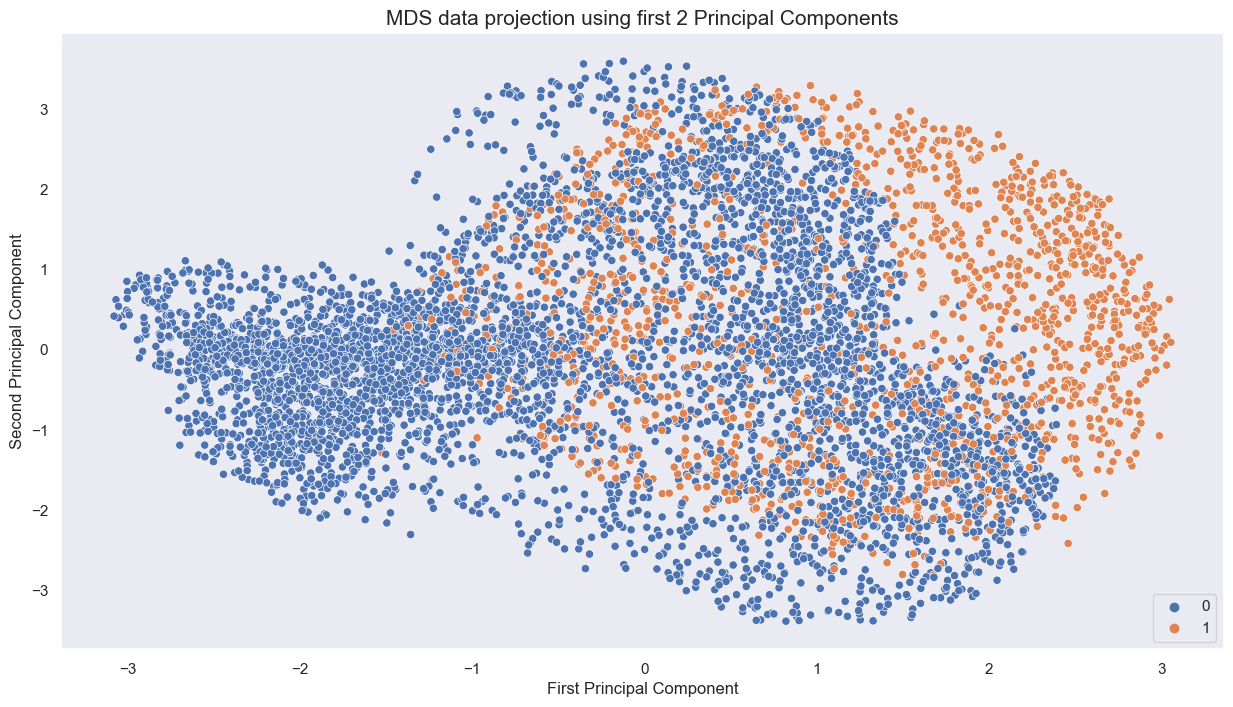

In [ ]:
# Project first two PCs
plt.figure(figsize=(15,8))
sns.scatterplot(x = Y[:,0], y = Y[:,1], hue=labels)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend(loc='lower right',  bbox_to_anchor=(0.5, 0., 0.5, 0.5))
plt.title('MDS data projection using first 2 Principal Components', fontsize=15)
plt.show()

Results are comparable w.r.t. what we got with PCA, which is what we were expecting.

We can procede with the Kernel-PCA implementation.

In [ ]:
def kernelPCA(X, n_components, width):
    # First, apply the kernel to the distance matrix
    K = gaussian_kernel(distance_matrix(X), width=width)

    # Then perform MDS using the Gram matrix obtained
    # from the double centering formula
    eigenvalues, Y, G = MDS(K, n_components, is_kernel=True)

    return eigenvalues, Y


We have to repeat point 2, this time applying Kernel-PCA by also varying the width of the kernel, so:

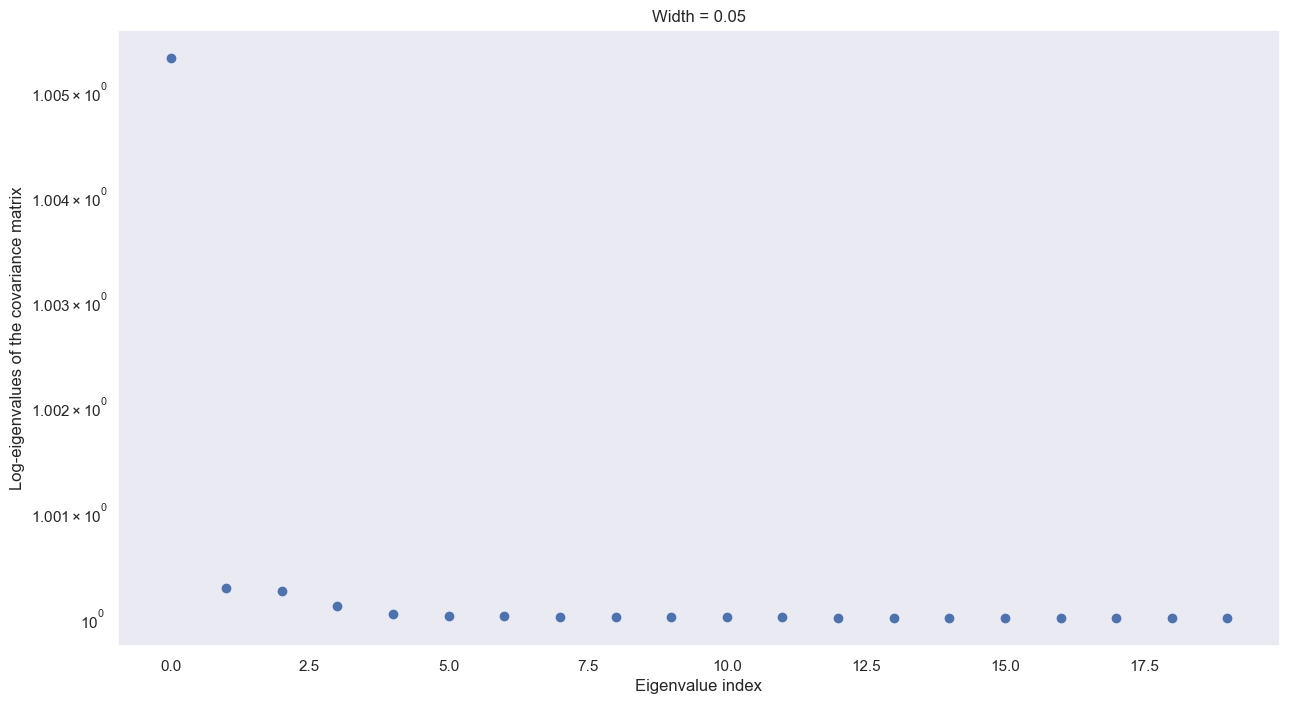

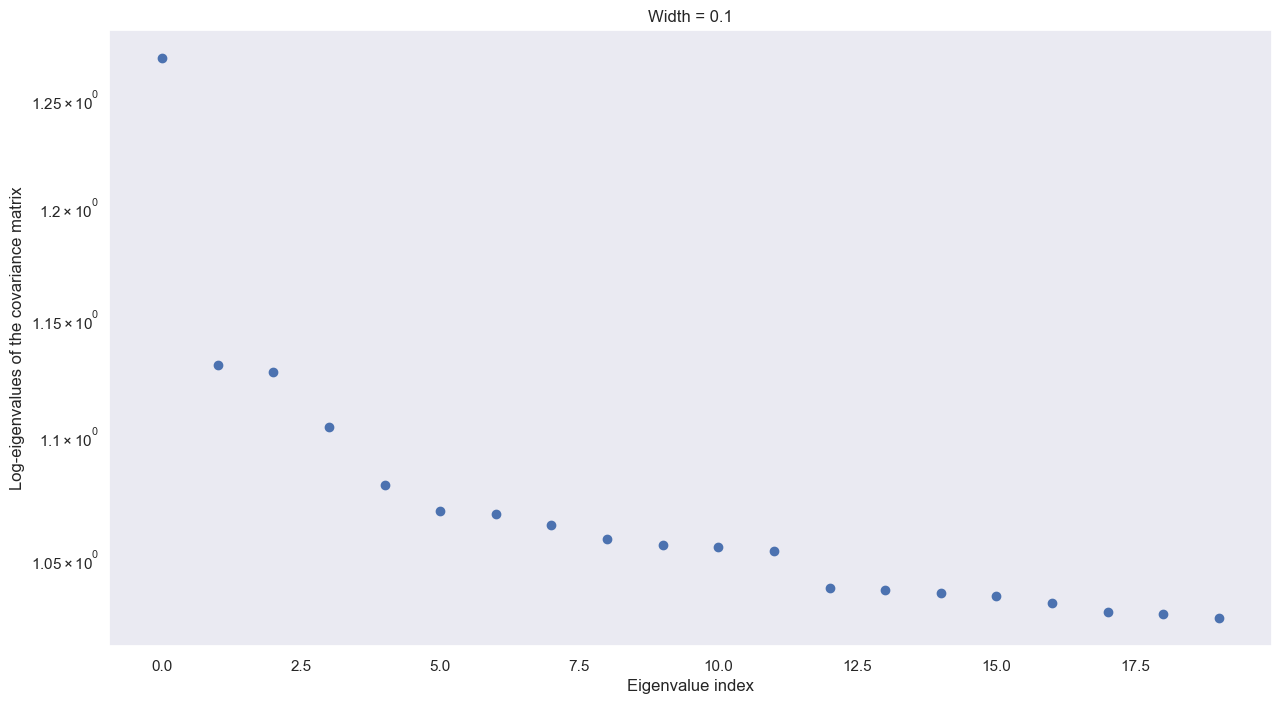

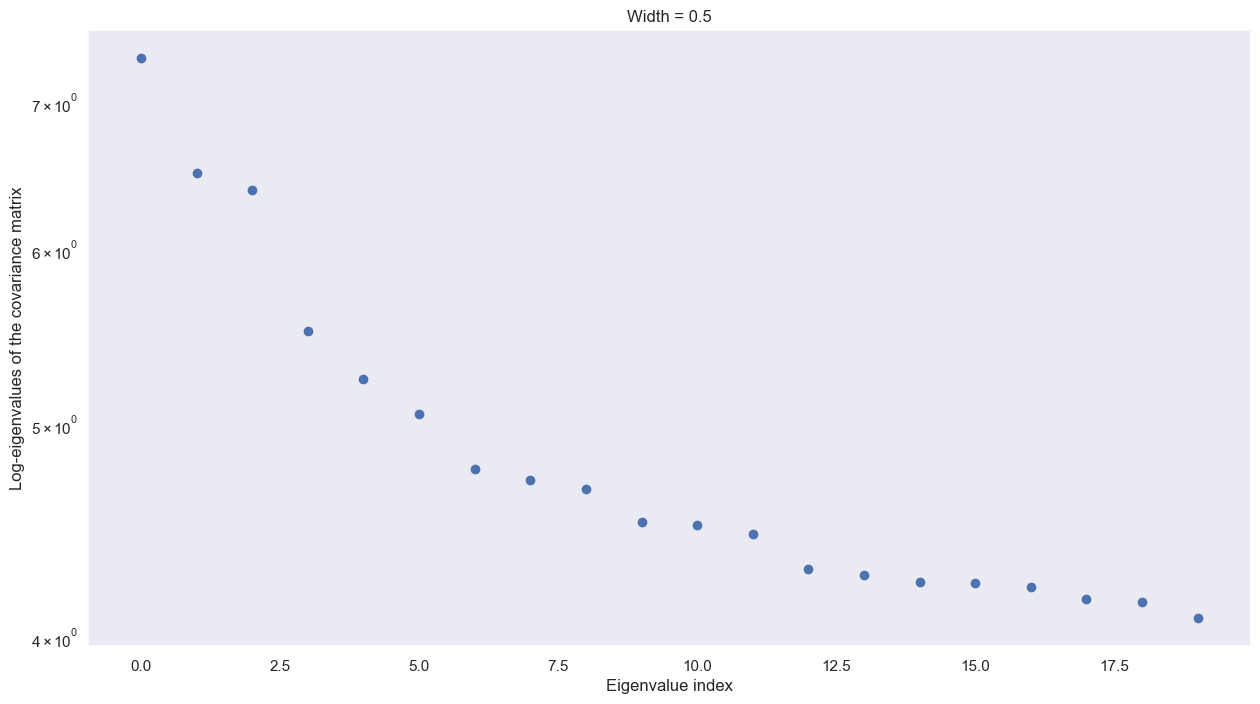

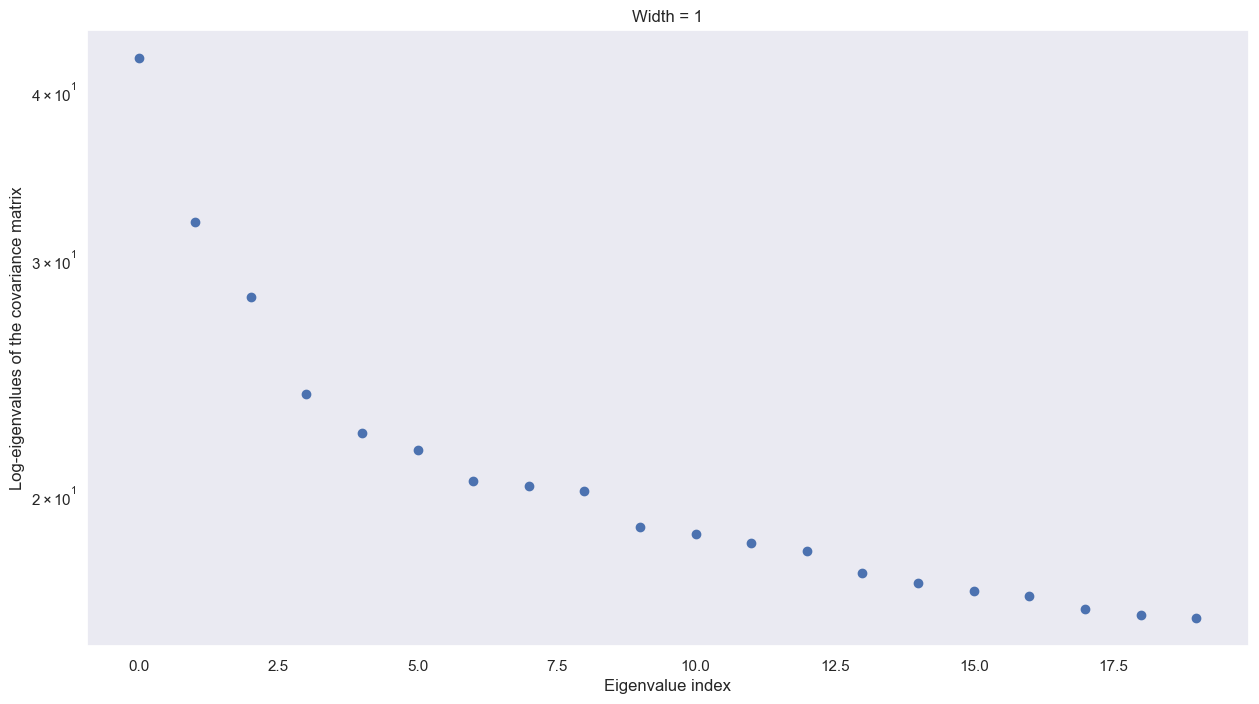

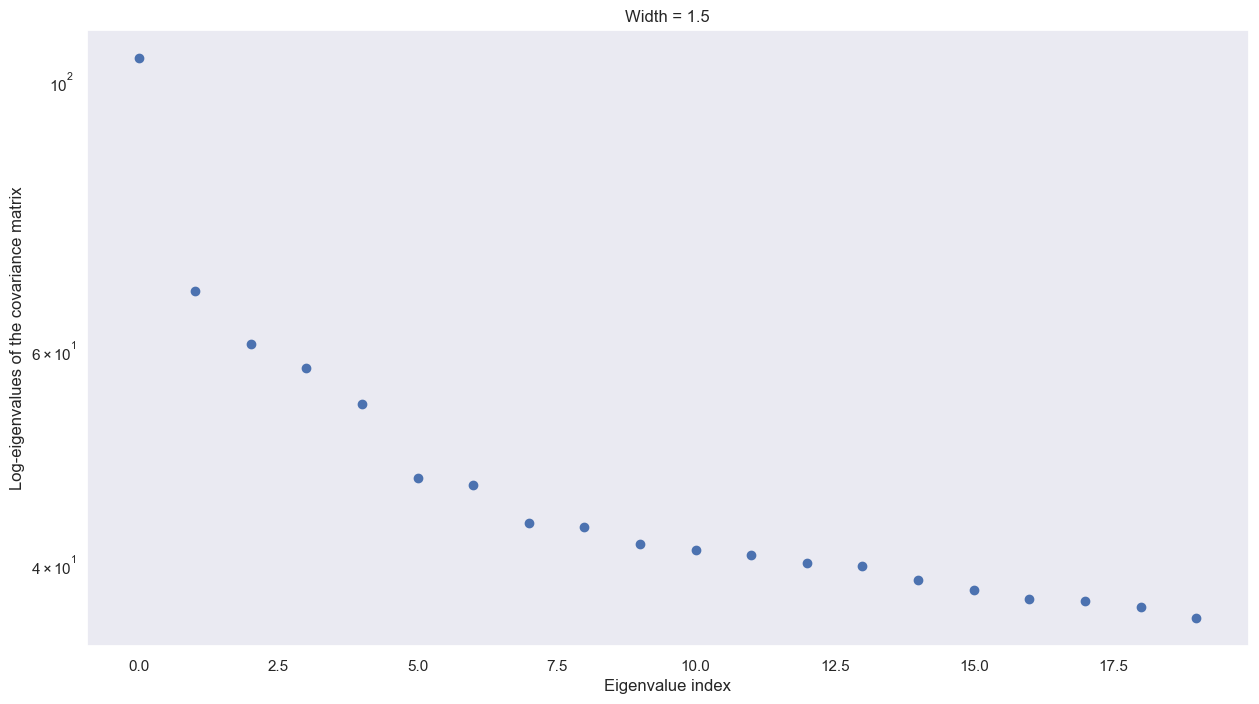

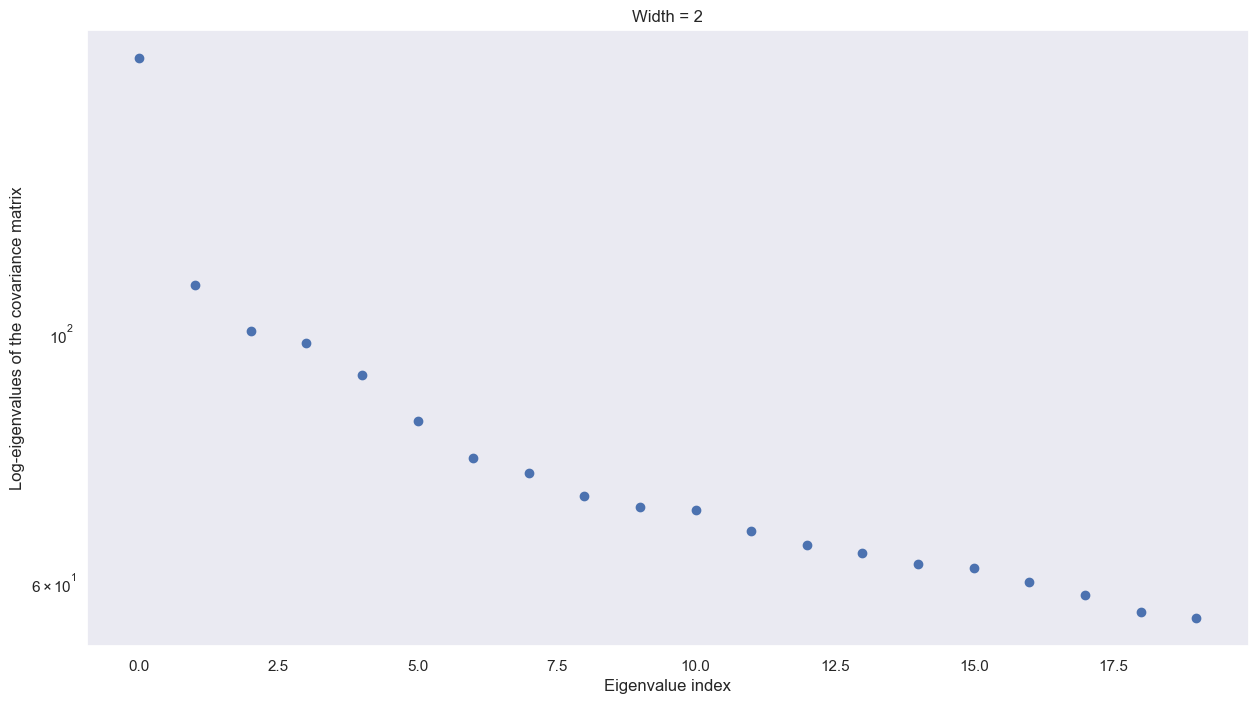

In [ ]:
widths = [0.05, 0.1, 0.5, 1, 1.5, 2]
Ys = {str(width) : None for width in widths}
for width in widths:
    eigenvalues, Y = kernelPCA(data, 20, width=width)
    Ys[str(width)] = Y
    # Plot the eigenvalue spectrum
    plt.figure(figsize=(15,8))
    plt.semilogy(eigenvalues, 'o')
    plt.ylabel("Log-eigenvalues of the covariance matrix")
    plt.xlabel("Eigenvalue index")
    plt.title(f"Width = {width}")
    plt.show()

Looking at the eigenvalue spectrum obtained using different kernel widths we can say that when width is set to $2$ there is a strong gap between $1^{st}$ and $2^{nd}$ but also $2^{nd}$ and $3^{rd}$ eigenvalue.

For this reason, and also looking at the results obtained plotting the first $2$ components for this latter case, in the next trials we're going to set the gaussian kernel's width = $2$.


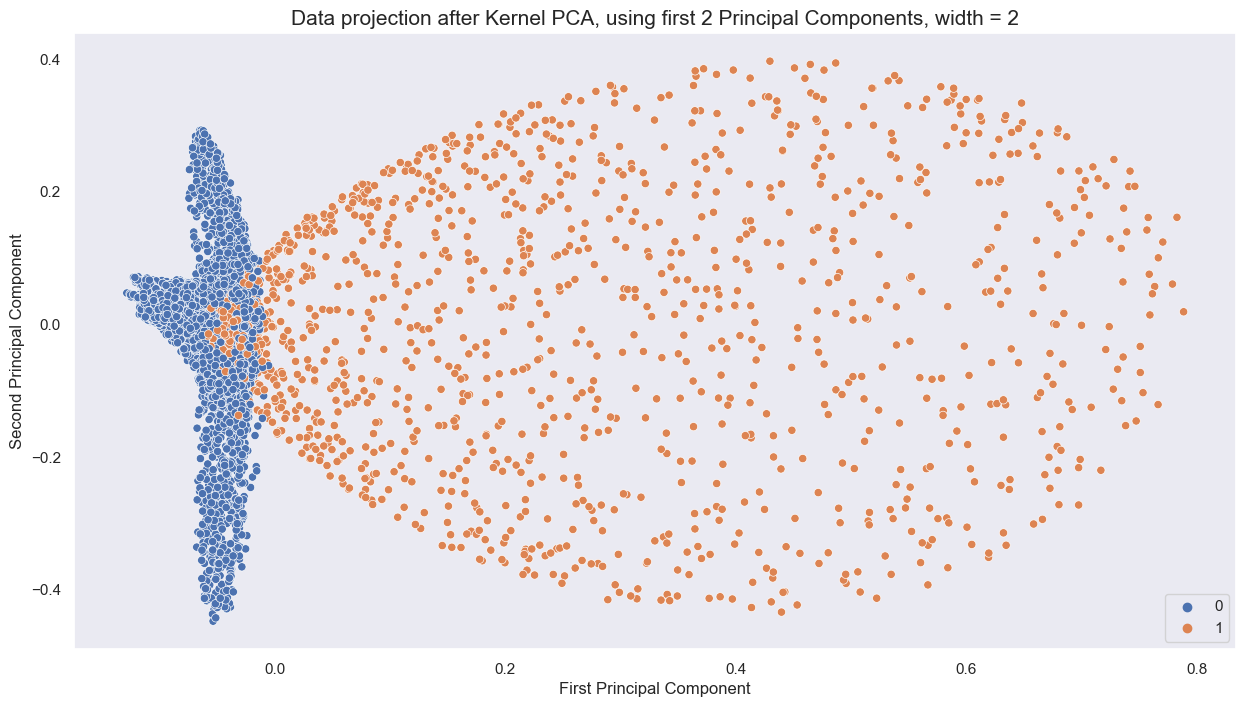

In [ ]:
# Project first two PCs
Y = Ys['2']
plt.figure(figsize=(15,8))
sns.scatterplot(x = Y[:,0], y = Y[:,1], hue=labels)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend(loc='lower right',  bbox_to_anchor=(0.5, 0., 0.5, 0.5))
plt.title(f'Data projection after Kernel PCA, using first 2 Principal Components, width = 2', fontsize=15)
plt.show()

Repeat point 3., i.e. apply logistic regression for a varying number of PCs ($1$ to $20$) and then compute the MI between prediction and ground truth data.

In [ ]:
def logistic_regression_on_variable_PC_kernel(X, n_components):
    _, Y = kernelPCA(X, n_components, width=2)
    Y_train, Y_test = Y[:train_size], Y[-test_size:]
    model = LogisticRegression()
    for n in range(1, n_components+1):
        model.fit(Y_train[:, :n], train_labels)
        result = model.predict(Y_test[:, :n])
        mutual_info = mutual_information(test_labels, result)
        print(f"Principal Components: {n}, Mutual Information: {mutual_info}, Accuracy: {accuracy_score(test_labels, result, normalize=True)}")

In [ ]:
logistic_regression_on_variable_PC_kernel(data, 20)
# width = 2

Principal Components: 1, Mutual Information: 0.43209600306893187, Accuracy: 0.9208860759493671
Principal Components: 2, Mutual Information: 0.4340701869888943, Accuracy: 0.9224683544303798
Principal Components: 3, Mutual Information: 0.43604437090885706, Accuracy: 0.9240506329113924
Principal Components: 4, Mutual Information: 0.43801855482881946, Accuracy: 0.9256329113924051
Principal Components: 5, Mutual Information: 0.4340701869888943, Accuracy: 0.9224683544303798
Principal Components: 6, Mutual Information: 0.4340701869888943, Accuracy: 0.9224683544303798
Principal Components: 7, Mutual Information: 0.4340701869888943, Accuracy: 0.9224683544303798
Principal Components: 8, Mutual Information: 0.4340701869888943, Accuracy: 0.9224683544303798
Principal Components: 9, Mutual Information: 0.4340701869888943, Accuracy: 0.9224683544303798
Principal Components: 10, Mutual Information: 0.4340701869888943, Accuracy: 0.9224683544303798
Principal Components: 11, Mutual Information: 0.43407018